# Homework 3 Group O
Florian Ulbricht 485080

Martin Hahn 484109

Mattis Rosenkranz 487615

David Andrés Mancera Carrillo 487621


In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 1 Square Wave Synthesis

#### a)

The following code is explicitly written for the given exercise assuming that

- N is an even number

- $ \Delta f = f_s / N = f_0 = 100 $

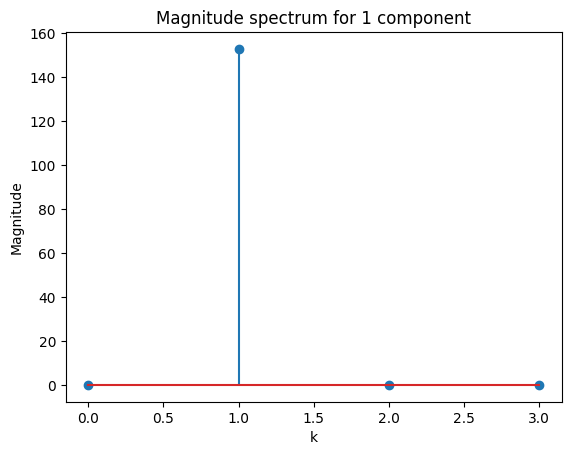

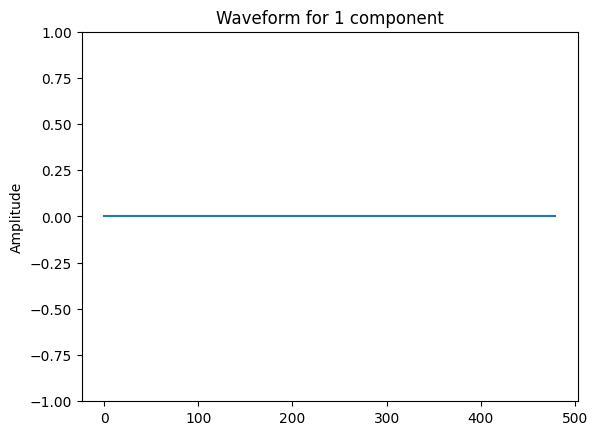

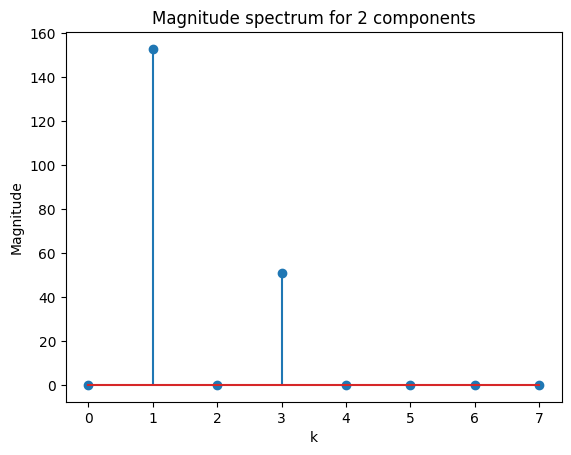

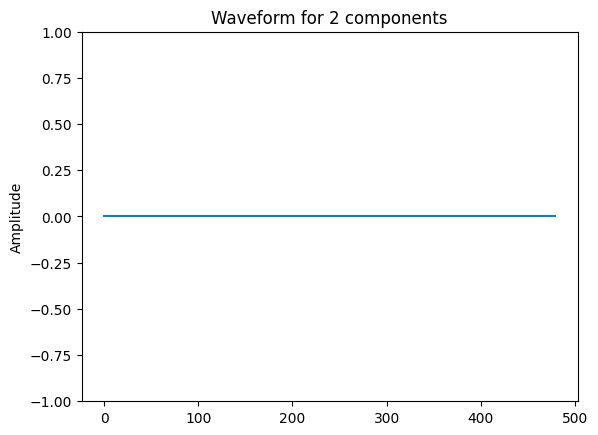

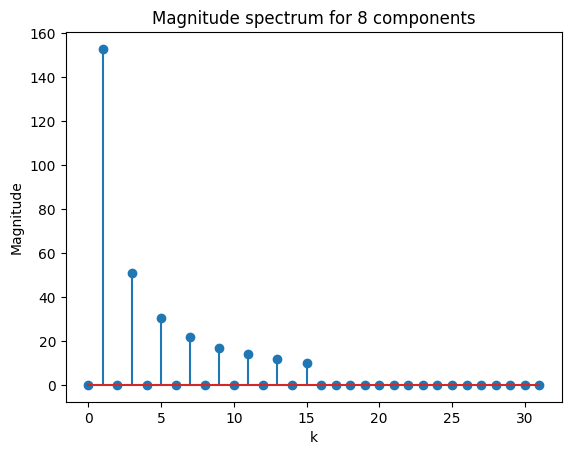

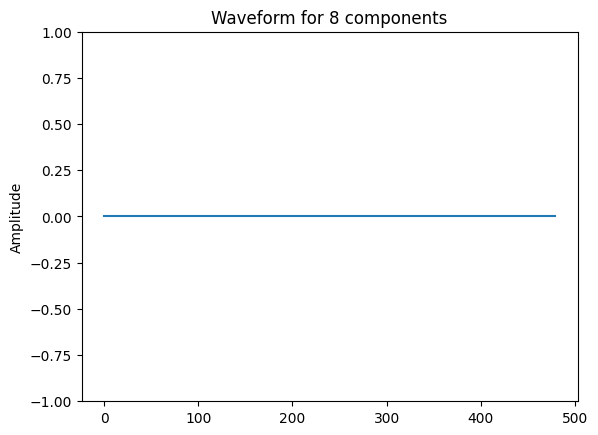

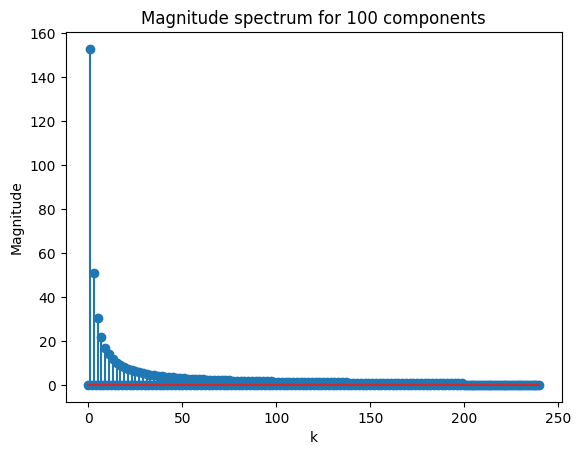

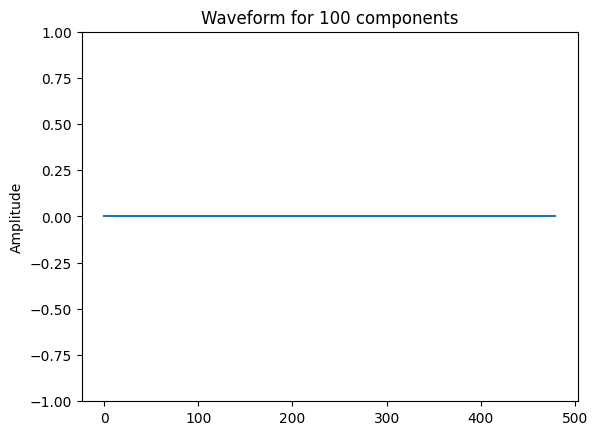

In [86]:
fs = 48_000
f0 = 100
N = 480
N_single_sided = N // 2 + 1
component_amounts = [1, 2, 8, 100]


def plot_spectrum_magnitude(X, title):
    figure, axes = plt.subplots()
    axes.set_title(title)
    axes.stem(np.abs(X))
    axes.set_xlabel('k')
    axes.set_ylabel('Magnitude')


def plot_waveform(x, title):
    figure, axes = plt.subplots()
    axes.set_title(title)
    axes.plot(x)
    axes.set_ylabel('Amplitude')
    axes.set_ylim([-1, 1])


for component_amount in component_amounts:
    X_single_sided = np.zeros(N_single_sided, dtype=complex)

    k_to_fill = np.ones(component_amount, dtype=int) + np.arange(0, component_amount) * 2

    for k in k_to_fill:
        X_single_sided[k] = N / np.pi * np.exp(-1j * np.pi / 2) / k

    X = np.append(X_single_sided, np.flip(X_single_sided[1:-1]))
    x = np.real(np.fft.ifft(X))

    title_suffix = f'for {component_amount} component{"s" if component_amount > 1 else ""}'
    plot_spectrum_magnitude(X_single_sided[:component_amount * 4], f'Magnitude spectrum {title_suffix}')
    plot_waveform(x, f'Waveform {title_suffix}')